### Library 및 Datasets

In [2]:
import os
import re
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import json
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix, coo_matrix
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
from torch_geometric.nn import SAGEConv, GATConv, GCNConv, GraphSAGE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch_geometric.transforms import RandomNodeSplit

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["TORCH_USE_CUDA_DSA"] = "1"


In [3]:
def generate_graph_data(num_nodes=1000):
    np.random.seed(1127)
    torch.manual_seed(1127)
    
    # 비선형 데이터
    X = np.random.rand(num_nodes, 5)  # 5차원
    y = np.sin(X[:, 0] * 3) + 0.1 * np.random.rand(num_nodes)
    
    edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))
    
    # PyG 데이터 변환
    return Data(
        x = torch.tensor(X, dtype = torch.float32),
        edge_index= edge_index,
        y = torch.tensor(y, dtype = torch.float32).unsqueeze(1),
    )

def generate_noisy_graph_data(num_nodes=1000, noise_type="gaussian", noise_level=0.1, outlier_ratio=0.05):
    """
    다양한 노이즈를 추가하여 그래프 데이터를 생성하는 함수

    Args:
    - num_nodes (int): 노드 개수
    - noise_type (str): 추가할 노이즈 유형 ("gaussian", "uniform", "outlier", "edge_noise")
    - noise_level (float): 노이즈의 강도 (가우시안 및 유니폼 노이즈)
    - outlier_ratio (float): 이상치(outlier) 비율

    Returns:
    - PyG Data 객체
    """
    np.random.seed(1127)
    torch.manual_seed(1127)
    
    X = np.random.rand(num_nodes, 5)  # 5차원 특징
    y = np.sin(X[:, 0] * 3) + 0.1 * np.random.rand(num_nodes)  # 기본 타겟
    
    if noise_type == "gaussian":
        y += np.random.normal(0, noise_level, size=num_nodes)
    elif noise_type == "uniform":
        y += np.random.uniform(-noise_level, noise_level, size=num_nodes)
    elif noise_type == "outlier":
        num_outliers = int(num_nodes * outlier_ratio)
        outlier_indices = np.random.choice(num_nodes, num_outliers, replace=False)
        y[outlier_indices] += np.random.normal(3, 1.0, size=num_outliers)  # 극단적인 변화

    # 그래프 구조적 노이즈 (엣지 변경)
    edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))
    if noise_type == "edge_noise":
        # 엣지에 무작위 잡음을 추가하여 구조적 변형 수행
        num_noisy_edges = int(edge_index.shape[1] * noise_level)
        noise_indices = np.random.choice(edge_index.shape[1], num_noisy_edges, replace=False)
        edge_index[:, noise_indices] = torch.randint(0, num_nodes, (2, num_noisy_edges))

    return Data(
        x=torch.tensor(X, dtype=torch.float32),
        edge_index=edge_index,
        y=torch.tensor(y, dtype=torch.float32).unsqueeze(1),
    )

def max_normalize(x):
    return x / np.max(np.abs(x)) if np.max(np.abs(x)) != 0 else x

def std_normalize(x):
    return (x - np.mean(x)) / np.std(x) if np.std(x) != 0 else np.zeros(len(x))

def int_normalize(x):
    return ((x - np.min(x)) / (np.max(x) - np.min(x)) * 2 - 1) if np.std(x) != 0 else np.zeros(len(x))

def simulate_ising(n, h0, J):
    G = nx.grid_2d_graph(n, n)
    l = np.linspace(-1.0, 1.0, n)
    
    s = np.random.choice([-1, 1], size=(n, n))
    # Placeholder for metropolis algorithm
    y = s.flatten()
    f = [[l[i], l[j]] for j in range(n) for i in range(n)]
    
    return G, [nx.to_scipy_sparse_matrix(G)], y, f

def parse_mean_fill(series, normalize=False):
    series = series.replace({',': ''}, regex=True)
    series = pd.to_numeric(series, errors='coerce')
    mean_val = series.mean()
    series.fillna(mean_val, inplace=True)
    
    if normalize:
        series = (series - mean_val) / series.std()
    
    return series.values

def read_county(prediction, year):
    adj = pd.read_csv("dataset/election/adjacency.txt", header=None, sep="\t", dtype=str, encoding="ISO-8859-1")
    fips2cty = {row[1]: row[0] for _, row in adj.iterrows() if pd.notna(row[1])}
    
    hh = adj.iloc[:, 1].ffill().astype(int)
    tt = adj.iloc[:, 3].astype(int)
    
    fips = sorted(set(hh).union(set(tt)))
    id2num = {id_: num for num, id_ in enumerate(fips)}
    
    G = nx.Graph()
    G.add_nodes_from(range(len(id2num)))
    G.add_edges_from([(id2num[h], id2num[t]) for h, t in zip(hh, tt)])
    
    # Load datasets
    VOT = pd.read_csv("dataset/election/election.csv")
    ICM = pd.read_csv("dataset/election/income.csv")
    POP = pd.read_csv("dataset/election/population.csv")
    EDU = pd.read_csv("dataset/election/education.csv")
    UEP = pd.read_csv("dataset/election/unemployment.csv")
    
    cty = pd.DataFrame({'FIPS': fips, 'County': [fips2cty.get(f, '') for f in fips]})
    vot = VOT[['fips_code', f'dem_{year}', f'gop_{year}']].rename(columns={'fips_code': 'FIPS'})
    icm = ICM[['FIPS', f'MedianIncome{min(max(2011, year), 2018)}']]
    pop = POP[['FIPS', f'R_NET_MIG_{min(max(2011, year), 2018)}', f'R_birth_{min(max(2011, year), 2018)}', f'R_death_{min(max(2011, year), 2018)}']]
    edu = EDU[['FIPS', f'BachelorRate{year}']]
    uep = UEP[['FIPS', f'Unemployment_rate_{min(max(2007, year), 2018)}']]
    
    dat = cty.merge(vot, on='FIPS', how='left')
    dat = dat.merge(icm, on='FIPS', how='left')
    dat = dat.merge(pop, on='FIPS', how='left')
    dat = dat.merge(edu, on='FIPS', how='left')
    dat = dat.merge(uep, on='FIPS', how='left')
    
    # Extract features and labels
    dem = parse_mean_fill(dat.iloc[:, 2])
    gop = parse_mean_fill(dat.iloc[:, 3])
    
    ff = np.zeros((len(dat), 7), dtype=np.float32)
    for i in range(6):
        ff[:, i] = parse_mean_fill(dat.iloc[:, i + 4], normalize=True)
    
    ff[:, 6] = (gop - dem) / (gop + dem)
    
    label_mapping = {
        "income": 0, "migration": 1, "birth": 2, "death": 3,
        "education": 4, "unemployment": 5, "election": 6
    }
    
    if prediction not in label_mapping:
        raise ValueError("Unexpected prediction type")
    
    pos = label_mapping[prediction]
    y = ff[:, pos]
    f = [np.concatenate((ff[i, :pos], ff[i, pos + 1:])) for i in range(len(dat))]
    
    return G, [csr_matrix(nx.adjacency_matrix(G))], y, f

def load_county_graph_data(prediction: str, year: int):
    G, A, labels, feats = read_county(prediction, year)

    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    pyg_data = from_networkx(G)

    edge_index = pyg_data.edge_index
    sorted_edges = torch.sort(edge_index, dim=0)[0]  # (u, v)와 (v, u)를 정렬
    unique_edges = torch.unique(sorted_edges, dim=1)  # 고유 엣지만 유지
    pyg_data.edge_index = unique_edges  # 중복 제거된 edge_index 적용

    pyg_data.x = torch.tensor(feats, dtype=torch.float)

    pyg_data.y = torch.tensor(labels, dtype=torch.float).view(-1, 1)

    return pyg_data

def read_transportation_network(network_name, net_skips, net_cols, netf_cols, flow_skips, flow_cols, V_range):
    # Load data
    dat_net = pd.read_csv(f"dataset/transportation/{network_name}/{network_name}_net.tntp", 
                           skiprows=net_skips, sep='\s+', usecols=net_cols, header=None).values
    dat_netf = pd.read_csv(f"dataset/transportation/{network_name}/{network_name}_net.tntp", 
                            skiprows=net_skips, sep='\s+', usecols=netf_cols, header=None).values
    dat_flow = pd.read_csv(f"dataset/transportation/{network_name}/{network_name}_flow.tntp", 
                            skiprows=flow_skips, sep='\s+', usecols=flow_cols, header=None).values
    
    # Map node labels to indices
    lb2id = {v: i for i, v in enumerate(V_range, start=1)}
    NV = len(V_range)
    
    # Create directed graph
    g = nx.DiGraph()
    g.add_nodes_from(range(1, NV + 1))
    
    for src, dst in dat_net:
        if src in lb2id and dst in lb2id:
            g.add_edge(lb2id[src], lb2id[dst])
    
    # Edge labels
    flow_dict = {}
    for src, dst, flow in dat_flow:
        if src in lb2id and dst in lb2id:
            flow_dict[(lb2id[src], lb2id[dst])] = flow
    
    y = np.array([flow_dict.get((e[0], e[1]), 0) for e in g.edges()])
    y = (y - np.mean(y)) / np.std(y)  # Standard normalization
    
    # Edge features
    netf_dict = {}
    for i in range(len(dat_net)):
        src, dst = dat_net[i]
        if src in lb2id and dst in lb2id:
            netf_dict[(lb2id[src], lb2id[dst])] = dat_netf[i]
    
    ff = np.array([netf_dict[e] for e in g.edges()])
    mean_ff = np.mean(ff, axis=0)
    std_ff = np.std(ff, axis=0)
    std_ff[std_ff == 0] = 1  # Prevent division by zero
    netf = (ff - mean_ff) / std_ff  
    
    f = list(netf)
    
    # Line graph transformation
    G1 = nx.Graph()
    G2 = nx.Graph()
    sorted_edges = sorted(g.edges())
    tuple2id = {e: i for i, e in enumerate(sorted_edges)}
    
    for u in g.nodes:
        innbrs = list(g.predecessors(u))
        outnbrs = list(g.successors(u))
        
        for v in innbrs:
            for w in outnbrs:
                if (v, u) in tuple2id and (u, w) in tuple2id:
                    G1.add_edge(tuple2id[(v, u)], tuple2id[(u, w)])
        
        for v in innbrs:
            for w in innbrs:
                if w > v and (v, u) in tuple2id and (w, u) in tuple2id:
                    G2.add_edge(tuple2id[(v, u)], tuple2id[(w, u)])
        
        for v in outnbrs:
            for w in outnbrs:
                if w > v and (u, v) in tuple2id and (u, w) in tuple2id:
                    G2.add_edge(tuple2id[(u, v)], tuple2id[(u, w)])
                    
    size = max(len(G1.nodes), len(G2.nodes))
    A1 = np.zeros((size, size))
    A2 = np.zeros((size, size))
    
    A1[:nx.number_of_nodes(G1), :nx.number_of_nodes(G1)] = nx.adjacency_matrix(G1).todense()
    A2[:nx.number_of_nodes(G2), :nx.number_of_nodes(G2)] = nx.adjacency_matrix(G2).todense()
    
    A = A1 + A2
    
    return nx.Graph(A), A, y, f

def load_trans_graph_data(city: str):
    if city == 'Anaheim':
        G, A, labels, feats = read_transportation_network(city, 8, [0, 1], [2, 3, 4, 7], 6, [0, 1, 3], range(1, 417))
    elif city == 'ChicagoSketch':
        G, A, labels, feats = read_transportation_network(city, 7, [0, 1], [2, 3, 4, 7], 1, [0, 1, 2], range(388, 934))

    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    pyg_data = from_networkx(G)

    edge_index = pyg_data.edge_index
    sorted_edges = torch.sort(edge_index, dim=0)[0]  # (u, v)와 (v, u)를 정렬
    unique_edges = torch.unique(sorted_edges, dim=1)  # 고유 엣지만 유지
    pyg_data.edge_index = unique_edges  # 중복 제거된 edge_index 적용

    pyg_data.x = torch.tensor(feats, dtype=torch.float)

    pyg_data.y = torch.tensor(labels, dtype=torch.float).view(-1, 1)

    return pyg_data

def read_twitch_network(cnm, dim_reduction=False, dim_embed=8):
    feats_all = []
    countries = ["DE", "ENGB", "ES", "FR", "PTBR", "RU"]
    
    for cn in countries:
        with open(f"dataset/twitch/{cn}/musae_{cn}_features.json", "r") as f:
            feats = json.load(f)
        feats_all.extend(feats.values())

    ndim = max(np.concatenate(feats_all)) + 1

    def feat_encode(feat_list):
        """특징 벡터를 원핫 인코딩 형태로 변환"""
        vv = np.zeros(ndim, dtype=np.float32)
        valid_indices = np.array(feat_list)
        
        if np.any(valid_indices >= ndim):
            raise ValueError(f"Index out of bounds! Max index: {max(valid_indices)}, ndim: {ndim}")
        
        vv[valid_indices] = 1.0
        return vv

    f_all = list(map(feat_encode, feats_all))

    with open(f"dataset/twitch/{cnm}/musae_{cnm}_features.json", "r") as f:
        feats = json.load(f)

    id2ft = {int(k) + 1: v for k, v in feats.items()}
    n = len(id2ft)
    assert min(id2ft.keys()) == 1 and max(id2ft.keys()) == n

    f = [feat_encode(id2ft[i]) for i in sorted(id2ft.keys())]

    if dim_reduction:
        f_matrix = np.stack(f_all, axis=1)
        U, S, Vt = svds(f_matrix, k=dim_embed)
        U *= np.sign(np.sum(U, axis=0))  # sign correction
        f = [U.T @ f_ for f_ in f]

    g = nx.Graph()
    g.add_nodes_from(range(1, len(f) + 1))

    links = pd.read_csv(f"dataset/twitch/{cnm}/musae_{cnm}_edges.csv")
    for _, row in links.iterrows():
        g.add_edge(row["from"] + 1, row["to"] + 1)

    trgts = pd.read_csv(f"dataset/twitch/{cnm}/musae_{cnm}_target.csv")
    nid2views = dict(zip(trgts["new_id"], trgts["views"]))
    y = std_normalize(np.log([nid2views[i - 1] + 1.0 for i in range(1, g.number_of_nodes() + 1)]))

    return g, [csr_matrix(nx.adjacency_matrix(g))], y, f

def load_twitch_graph_data(cnm: str):
    G, A, labels, feats = read_twitch_network(cnm)

    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    pyg_data = from_networkx(G)

    edge_index = pyg_data.edge_index
    sorted_edges = torch.sort(edge_index, dim=0)[0]  # (u, v)와 (v, u)를 정렬
    unique_edges = torch.unique(sorted_edges, dim=1)  # 고유 엣지만 유지
    pyg_data.edge_index = unique_edges  # 중복 제거된 edge_index 적용

    pyg_data.x = torch.tensor(feats, dtype=torch.float)

    pyg_data.y = torch.tensor(labels, dtype=torch.float).view(-1, 1)

    return pyg_data

def load_wiki_graph_data(category):
    edge_path = f'dataset/wikipedia/{category}/musae_{category}_edges.csv'
    feature_path = f'dataset/wikipedia/{category}/musae_{category}_features.json'
    target_path = f'dataset/wikipedia/{category}/musae_{category}_target.csv'
    
    # 엣지 데이터 로드
    edge_df = pd.read_csv(edge_path)
    edge_index = torch.tensor(edge_df.values.T, dtype=torch.long)
    
    # 피처 데이터 로드
    with open(feature_path, "r") as f:
        features_dict = json.load(f)
    
    node_ids = sorted(map(int, features_dict.keys()))  # 노드 ID 정렬
    node_id_map = {old_id: new_id for new_id, old_id in enumerate(node_ids)}
    
    num_nodes = len(node_ids)
    num_features = max(max(v) for v in features_dict.values()) + 1  # 가장 큰 feature index 찾기
    x = torch.zeros((num_nodes, num_features), dtype=torch.float32)
    
    for node, features in features_dict.items():
        new_id = node_id_map[int(node)]  # 노드 ID 변환
        x[new_id, features] = 1.0  # One-hot 인코딩
    
    # 타겟 데이터 로드
    target_df = pd.read_csv(target_path)
    target_df["id"] = target_df["id"].map(node_id_map)  # 노드 ID 변환
    target_df = target_df.dropna().astype(int)  # 변환되지 않은 노드 제거
    
    # y = torch.zeros(num_nodes, dtype=torch.long)
    y = torch.zeros((num_nodes, 1), dtype=torch.long)  # [, 1] 형태로 변경
    y[target_df["id"].values] = torch.tensor(target_df["target"].values, dtype=torch.long).view(-1, 1)
    
    # PyG Data 객체 생성
    graph_data = Data(x=x, edge_index=edge_index, y=y)
    return graph_data

def set_seed(seed=1127):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def to_numpy(tensor):
    """PyTorch Tensor → NumPy 변환 후 1차원으로 변형"""
    if isinstance(tensor, torch.Tensor):
        return tensor.cpu().numpy().squeeze()
    elif isinstance(tensor, np.ndarray):
        return tensor.squeeze()
    else:
        raise TypeError(f"Unsupported data type: {type(tensor)}")
 
def sort_by_y(x, y, *intervals):
    sort_idx = np.argsort(to_numpy(y).ravel())  # Y값을 기준으로 정렬할 인덱스
    sorted_x = to_numpy(x).ravel()[sort_idx]
    sorted_y = to_numpy(y).ravel()[sort_idx]
    sorted_intervals = [to_numpy(interval).ravel()[sort_idx] for interval in intervals]
    return sorted_x, sorted_y, sorted_intervals

def split_graph_data(graph_data, test_ratio=0.2):
    """
    GNN용 Train-Test Split (edge_index를 올바르게 재매핑하여 유지)
    """
    num_nodes = graph_data.x.shape[0]  # 전체 노드 개수
    num_test = int(num_nodes * test_ratio)  # 테스트 데이터 노드 개수

    # 랜덤하게 Train/Test 노드 인덱스 선택
    indices = torch.randperm(num_nodes)
    test_nodes = indices[:num_test]
    train_nodes = indices[num_test:]

    # 노드 마스크 생성
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[train_nodes] = True
    test_mask[test_nodes] = True

    # Train/Test용 edge_index 필터링
    train_edge_mask = train_mask[graph_data.edge_index[0]] & train_mask[graph_data.edge_index[1]]
    test_edge_mask = test_mask[graph_data.edge_index[0]] & test_mask[graph_data.edge_index[1]]

    # Train용 edge_index와 노드 인덱스 재매핑
    train_edge_index = graph_data.edge_index[:, train_edge_mask]
    train_node_map = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(train_nodes)}
    train_edge_index = torch.tensor(
        [[train_node_map[idx.item()] for idx in train_edge_index[0]],
         [train_node_map[idx.item()] for idx in train_edge_index[1]]],
        dtype=torch.long
    )

    # Test용 edge_index와 노드 인덱스 재매핑
    test_edge_index = graph_data.edge_index[:, test_edge_mask]
    test_node_map = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(test_nodes)}
    test_edge_index = torch.tensor(
        [[test_node_map[idx.item()] for idx in test_edge_index[0]],
         [test_node_map[idx.item()] for idx in test_edge_index[1]]],
        dtype=torch.long
    )

    # Train 데이터 생성
    train_data = Data(
        x=graph_data.x[train_mask],
        y=graph_data.y[train_mask],
        edge_index=train_edge_index
    )

    # Test 데이터 생성
    test_data = Data(
        x=graph_data.x[test_mask],
        y=graph_data.y[test_mask],
        edge_index=test_edge_index
    )

    # 결과 출력
    print(f"Train Nodes: {train_data.x.shape[0]}, Train Edges: {train_data.edge_index.shape[1]}")
    print(f"Train edge_index 최대값: {train_data.edge_index.max().item()}")
    print(f"Test Nodes: {test_data.x.shape[0]}, Test Edges: {test_data.edge_index.shape[1]}")
    print(f"Test edge_index 최대값: {test_data.edge_index.max().item()}")

    return train_data, test_data

def augment_features(x, tau):
    if isinstance(tau, float):  # tau가 float이면 변환
        tau = torch.tensor([tau])
    
    tau = tau.view(-1, 1)
    tau_transformed = (tau - 0.5) * 12 # 분위수 값 변환: 학습 안정성 증가
    
    return torch.cat((x, tau_transformed.expand(x.size(0), -1)), dim = 1)

def coverage_width(y_true, y_low, y_upper):
    coverage = ((y_true >= y_low) & (y_true <= y_upper)).float().mean()
    width = (y_upper - y_low).float().abs().mean()
    
    return coverage, width
    
def evaluate_model_performance(preds_low, preds_upper, targets, target=0.9):
    coverage = np.mean((targets >= preds_low) & (targets <= preds_upper))
    
    interval_width = np.mean(preds_upper - preds_low)
    normalized_interval_width = interval_width / (np.max(targets) - np.min(targets))
    
    median_pred = (preds_low + preds_upper) / 2    # 신뢰구간 중앙값
    mpe = np.mean(np.abs(median_pred - targets)) # 예측 구간 중심이 실제값과 얼마나 가까운지
    
    sharpness = np.mean(np.square(preds_upper - preds_low)) # 예측 구간의 날카로움: 제곱을 사용해 큰 폭일수록 더 강한 패널티
    
    alpha = 0.5
    penalties = np.where(targets < preds_low, preds_low - targets, np.where(targets > preds_upper, targets - preds_upper, 0))  
    winkler = np.mean(interval_width + 2 * alpha * penalties) # 신뢰구간이 실제값을 포함하지 않으면 패널티 적용
    
    MCT = interval_width * abs(coverage - target)     # 조정된 Coverage Tradeoff 지표 (MCT)

    print(f"예측 관련 - Coverage Rate (CR) ⬆: {coverage:.2f}, Mean Prediction Error (MPE) ⬇: {mpe:.2f}")
    print(f"구간 관련 - Interval Width (IW) ⬇: {interval_width:.2f}, Sharpness ⬇: {sharpness:.2f}, Winkler Score (WS) ⬇: {winkler:.2f}")
    print(f"종합 - MisCoverage Trade-off (MCT) ⬇: {MCT:.2f}")
    
    # return {
    #     "Coverage Rate (CR)": coverage,
    #     "Interval Width (IW)": interval_width,
    #     "Normalized IW": normalized_interval_width,
    #     "Mean Prediction Error (MPE)": mpe,
    #     "Sharpness": sharpness,
    #     "Winkler Score (WS)": winkler,
    #     "MisCoverage Trade-off (MCT)": MCT
    # }

set_seed(1127)  

In [4]:
# 기본 비선형 그래프 데이터
graph_data_basic = generate_graph_data(num_nodes=1000)

# 노이즈 비선형 그래프 데이터
# graph_data_noise_gaussian = generate_noisy_graph_data(num_nodes=1000, noise_type='gaussian', noise_level=0.3)
# graph_data_noise_uniform = generate_noisy_graph_data(num_nodes=1000, noise_type='uniform', noise_level=0.3)
# graph_data_noise_outlier = generate_noisy_graph_data(num_nodes=1000, noise_type='outlier', noise_level=0.3)
# graph_data_noise_edge = generate_noisy_graph_data(num_nodes=1000, noise_type='edge_noise', noise_level=0.3)

# County 데이터셋
# graph_data_county_edu = load_county_graph_data('education', 2012)
# graph_data_county_elec = load_county_graph_data('election', 2012)
# graph_data_county_inc = load_county_graph_data('income', 2012)
# graph_data_county_unemp = load_county_graph_data('unemployment', 2012)

# Twitch 데이터셋
# graph_data_twitch_de = load_twitch_graph_data('DE')
# graph_data_twitch_engb = load_twitch_graph_data('ENGB')
# graph_data_twitch_es = load_twitch_graph_data('ES')
# graph_data_twitch_fr = load_twitch_graph_data('FR')
# graph_data_twitch_ptbr = load_twitch_graph_data('PTBR')
# graph_data_twitch_ru = load_twitch_graph_data('RU')

# Wikipedia 데이터
# graph_data_wiki_ch = load_wiki_graph_data('chameleon')
# graph_data_wiki_cr = load_wiki_graph_data('crocodile')
# graph_data_wiki_sq = load_wiki_graph_data('squirrel')

# Transfortation 데이터셋
# graph_data_trans_ana = load_trans_graph_data('Anaheim')
# graph_data_trans_chica = load_trans_graph_data('ChicagoSketch')

### 추가 데이터셋

In [11]:
import torch
from torch_geometric.datasets import  graph_generator
from torch_geometric.data import Data
from torch_geometric.utils import degree
from torch_geometric.utils import get_laplacian, to_networkx
import networkx as nx

In [ ]:
# BAGraph (현실적 네트워크)

generator = graph_generator.BAGraph(num_nodes=100, num_edges=2)
data = generator.generate()
data.x = torch.randn(data.num_nodes, 16)
deg = degree(data.edge_index[0], num_nodes=data.num_nodes)
data.y = deg.unsqueeze(1) + torch.randn(data.num_nodes, 1) * 0.1

print(f"노드 수: {data.num_nodes}, 엣지 수: {data.num_edges}")
print(f"피처 크기: {data.x.shape}, 타겟 크기: {data.y.shape}")

In [ ]:
# ERGraph (무작위성 테스트)

# ERGraph 생성
generator = graph_generator.ERGraph(num_nodes=100, edge_prob=0.2)
data = generator.generate()
data.x = torch.randn(data.num_nodes, 16)

G = to_networkx(data, to_undirected=True)
clustering = torch.tensor([nx.clustering(G, n) for n in range(data.num_nodes)], dtype=torch.float)
data.y = clustering.unsqueeze(1) + torch.randn(data.num_nodes, 1) * 0.05

print(f"노드 수: {data.num_nodes}, 엣지 수: {data.num_edges}")
print(f"피처 크기: {data.x.shape}, 타겟 크기: {data.y.shape}")

In [ ]:
# GridGraph (공간적 데이터)

# GridGraph 생성
generator = graph_generator.GridGraph(height=10, width=10)  # 10x10 격자
data = generator.generate()
data.x = torch.randn(data.num_nodes, 16)

coords = torch.tensor([[i // 10, i % 10] for i in range(data.num_nodes)], dtype=torch.float)
data.y = coords.sum(dim=1).unsqueeze(1) + torch.randn(data.num_nodes, 1) * 0.2

print(f"노드 수: {data.num_nodes}, 엣지 수: {data.num_edges}")
print(f"피처 크기: {data.x.shape}, 타겟 크기: {data.y.shape}")

In [ ]:
# TreeGraph (계층적 데이터)

# TreeGraph 생성
generator = graph_generator.TreeGraph(depth=4, branching_factor=2)  # 깊이 4, 분기 2
data = generator.generate()
data.x = torch.randn(data.num_nodes, 16)

G = to_networkx(data, to_undirected=False)  # 단방향 트리
depths = nx.single_source_shortest_path_length(G, 0)  # 루트 노드 0에서 깊이
data.y = torch.tensor([depths[n] for n in range(data.num_nodes)], dtype=torch.float).unsqueeze(1)
data.y = data.y + torch.randn(data.num_nodes, 1) * 0.1  # 노이즈 추가

print(f"노드 수: {data.num_nodes}, 엣지 수: {data.num_edges}")
print(f"피처 크기: {data.x.shape}, 타겟 크기: {data.y.shape}")

### 개선 실험 수행

In [6]:
# 데이터 분리
train_data, test_data = split_graph_data(graph_data_basic)

# Train 데이터에서 min/max 구하기
train_min = train_data.x.min()
train_max = train_data.x.max()
y_min = train_data.y.min()
y_max = train_data.y.max()

# 정규화 함수
def normalize(tensor, min_val, max_val):
    return (tensor - min_val) / (max_val - min_val)

train_data.x = normalize(train_data.x, train_min, train_max)
test_data.x = normalize(test_data.x, train_min, train_max)
train_data.y = normalize(train_data.y, y_min, y_max)
test_data.y = normalize(test_data.y, y_min, y_max)

color = sns.color_palette("colorblind")

Train Nodes: 800, Train Edges: 1294
Train edge_index 최대값: 799
Test Nodes: 200, Test Edges: 77
Test edge_index 최대값: 199


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from torch_geometric.data import DataLoader  # 배치 처리를 위해 필요
from torch_geometric.data import Data

# 모델과 손실 함수 정의 (질문에서 제공된 코드 그대로 사용)
class EnhancedGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, heads=4):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=heads, dropout=0.2)
        self.norm = nn.LayerNorm(hidden_dim * heads + in_dim)
        self.fc = nn.Linear(hidden_dim * heads + in_dim, 2)
    
    def forward(self, x, edge_index):
        x_initial = x
        x = F.relu(self.conv1(x, edge_index))
        x = torch.cat([x, x_initial], dim=-1)
        x = self.norm(x)
        return self.fc(x)

class GraphRQRLoss(nn.Module):
    def __init__(self, base_target=0.9, lambda_width=1.5, max_width=0.3, diversity_factor=0.1):
        super().__init__()
        self.base_target = base_target
        self.lw = lambda_width
        self.max_width = max_width
        self.df = diversity_factor
    
    def forward(self, preds, x, edge_index):
        q1, q2 = preds[:, 0], preds[:, 1]
        width = q2 - q1
        
        # 노드별 타겟 동적 조정
        node_target = self.base_target + torch.tanh(x.mean(dim=1, keepdim=True)) * 0.1
        
        diff1 = node_target - q1
        diff2 = node_target - q2
        
        rqr_loss = torch.maximum(diff1 * diff2 * (self.base_target + 2 * self.lw),
                                diff2 * diff1 * (self.base_target + 2 * self.lw - 1))
        width_loss = self.lw * torch.square(torch.clamp(width - self.max_width, min=0))
        diversity_loss = -self.df * torch.std(width)
        
        return torch.mean(rqr_loss + width_loss) + diversity_loss

# 학습 함수 정의
def train(model, train_data, loss_fn, optimizer, device):
    model.train()
    
    train_data = train_data.to(device)
    optimizer.zero_grad()
    
    # 모델 예측
    preds = model(train_data.x, train_data.edge_index)
    
    # 손실 계산
    loss = loss_fn(preds, train_data.x, train_data.edge_index)
    
    # 역전파 및 최적화
    loss.backward()
    optimizer.step()
    
    return loss.item()

# 평가 함수 정의 (선택적)
def evaluate(model, test_data, loss_fn, device):
    model.eval()
    with torch.no_grad():
        test_data = test_data.to(device)
        preds = model(test_data.x, test_data.edge_index)
        loss = loss_fn(preds, test_data.x, test_data.edge_index)
    return loss.item()

In [19]:
# 메인 학습 루프
def main():
    in_dim = train_data.x.shape[1]
    hidden_dim = 32
    heads = 4
    learning_rate = 1e-3
    weight = 1e-3
    epochs = 500
    batch_size = 32
    
    # 디바이스 설정
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # 모델, 손실 함수, 옵티마이저 초기화
    model = EnhancedGNN(in_dim=in_dim, hidden_dim=hidden_dim, heads=heads).to(device)
    loss_fn = GraphRQRLoss(base_target=0.9, lambda_width=1.5, max_width=0.3, diversity_factor=0.1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
    
    # 학습 루프
    for epoch in range(epochs):
        train_loss = train(model, train_data, loss_fn, optimizer, device)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")
        
        # 평가 (필요 시 추가)
        test_loss = evaluate(model, test_data, loss_fn, device)
        print(f"Test Loss: {test_loss:.4f}")
    
    # # 학습 완료 후 모델 저장 (선택적)
    # torch.save(model.state_dict(), "enhanced_gnn.pth")
    # print("Model saved to 'enhanced_gnn.pth'")

if __name__ == "__main__":
    main()

Epoch 1/500, Train Loss: 2.1435
Test Loss: 1.6051
Epoch 2/500, Train Loss: 1.4104
Test Loss: 0.9451
Epoch 3/500, Train Loss: 0.7432
Test Loss: 0.4249
Epoch 4/500, Train Loss: 0.2921
Test Loss: 0.0209
Epoch 5/500, Train Loss: -0.1172
Test Loss: -0.3006
Epoch 6/500, Train Loss: -0.3955
Test Loss: -0.5875
Epoch 7/500, Train Loss: -0.7369
Test Loss: -0.8857
Epoch 8/500, Train Loss: -1.0355
Test Loss: -1.2387
Epoch 9/500, Train Loss: -1.4290
Test Loss: -1.6741
Epoch 10/500, Train Loss: -1.8801
Test Loss: -2.2112
Epoch 11/500, Train Loss: -2.4237
Test Loss: -2.8630
Epoch 12/500, Train Loss: -3.1295
Test Loss: -3.6409
Epoch 13/500, Train Loss: -3.9899
Test Loss: -4.5539
Epoch 14/500, Train Loss: -4.8728
Test Loss: -5.6096
Epoch 15/500, Train Loss: -5.9791
Test Loss: -6.8164
Epoch 16/500, Train Loss: -7.1559
Test Loss: -8.1819
Epoch 17/500, Train Loss: -8.5680
Test Loss: -9.7129
Epoch 18/500, Train Loss: -10.1532
Test Loss: -11.4164
Epoch 19/500, Train Loss: -12.0202
Test Loss: -13.3009
Epoch 

KeyboardInterrupt: 

In [5]:
class GQNN_D(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc_tau = nn.Linear(hidden_dim, 2)  # tau_low, tau_upper 출력
        self.fc_pred = nn.Linear(hidden_dim, 2)  # pred_low, pred_upper 출력
        
        nn.init.xavier_uniform_(self.fc_tau.weight)
        nn.init.xavier_uniform_(self.fc_pred.weight)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        taus = torch.sigmoid(self.fc_tau(x))
        tau_low = taus[:, 0:1]
        tau_upper = taus[:, 1:2]
        tau_low_final = torch.min(tau_low, tau_upper)
        tau_upper_final = torch.max(tau_low, tau_upper)
        
        preds = self.fc_pred(x)
        pred_low = preds[:, 0:1]
        pred_upper = preds[:, 1:2]
        pred_low_final = torch.min(pred_low, pred_upper)
        pred_upper_final = torch.max(pred_low, pred_upper)
        
        preds_low = pred_low_final
        preds_upper = pred_upper_final
        
        return preds_low, preds_upper, tau_low_final, tau_upper_final

In [9]:
class IQRLoss(nn.Module):
    def __init__(self, target_coverage=0.9, num_epochs=500, lambda_reg=0.1, lambda_width=0.5):
        super().__init__()
        self.alpha = target_coverage  # 목표 커버리지 (예: 0.9)
        self.n = num_epochs
        self.lambda_reg = lambda_reg  # tau 간격 제약 가중치
        self.lambda_width = lambda_width  # 구간 너비 패널티 가중치
    
    def quantile_loss(self, target, preds, tau):
        diff = target - preds
        return torch.mean(torch.where(diff >= 0, tau * diff, (tau - 1) * diff))
    
    def coverage_loss(self, target, preds_low, preds_upper):
        inside = ((preds_low <= target) & (target <= preds_upper)).float()
        p_hat = torch.mean(inside)
        coverage_loss = (self.alpha - p_hat) ** 2
        w = torch.sigmoid((p_hat - self.alpha) / 0.01)
        width_penalty = torch.mean(preds_upper - preds_low)
        return (1 - w) * coverage_loss + w * self.lambda_width * width_penalty
    
    def forward(self, preds_low, preds_upper, tau_low, tau_upper, target, epoch):
        # 1. Quantile Loss
        loss_low = self.quantile_loss(target, preds_low, tau_low)
        loss_upper = self.quantile_loss(target, preds_upper, tau_upper)
        qr_loss = loss_low + loss_upper
        
        # 2. Coverage Loss
        coverage_loss = self.coverage_loss(target, preds_low, preds_upper)
        
        # 3. tau 간격 제약 (선택적)
        tau_diff_loss = F.relu((tau_upper - tau_low) - 0.5).mean()  # tau 간격이 0.5를 초과하지 않도록
        
        # 최종 손실
        total_loss = qr_loss + coverage_loss + self.lambda_reg * tau_diff_loss
        
        if epoch % (self.n // 50) == 0:
            print(f"Epoch {epoch}: QR Loss = {qr_loss.item():.2f}, Coverage Loss = {coverage_loss.item():.2f}")
        
        return total_loss

Epoch 0: QR Loss = 0.46, Coverage Loss = 0.71
Epoch 0: Loss = 1.17, Coverage = 0.06, Width = 0.10
--------------------------------------------------
Epoch 10: QR Loss = 0.28, Coverage Loss = 0.47
Epoch 10: Loss = 0.74, Coverage = 0.22, Width = 0.17
--------------------------------------------------
Epoch 20: QR Loss = 0.24, Coverage Loss = 0.69
Epoch 20: Loss = 0.93, Coverage = 0.07, Width = 0.07
--------------------------------------------------
Epoch 30: QR Loss = 0.23, Coverage Loss = 0.54
Epoch 30: Loss = 0.77, Coverage = 0.16, Width = 0.17
--------------------------------------------------
Epoch 40: QR Loss = 0.22, Coverage Loss = 0.39
Epoch 40: Loss = 0.61, Coverage = 0.28, Width = 0.24
--------------------------------------------------
Epoch 50: QR Loss = 0.19, Coverage Loss = 0.30
Epoch 50: Loss = 0.49, Coverage = 0.35, Width = 0.28
--------------------------------------------------
Epoch 60: QR Loss = 0.17, Coverage Loss = 0.19
Epoch 60: Loss = 0.37, Coverage = 0.46, Width = 0

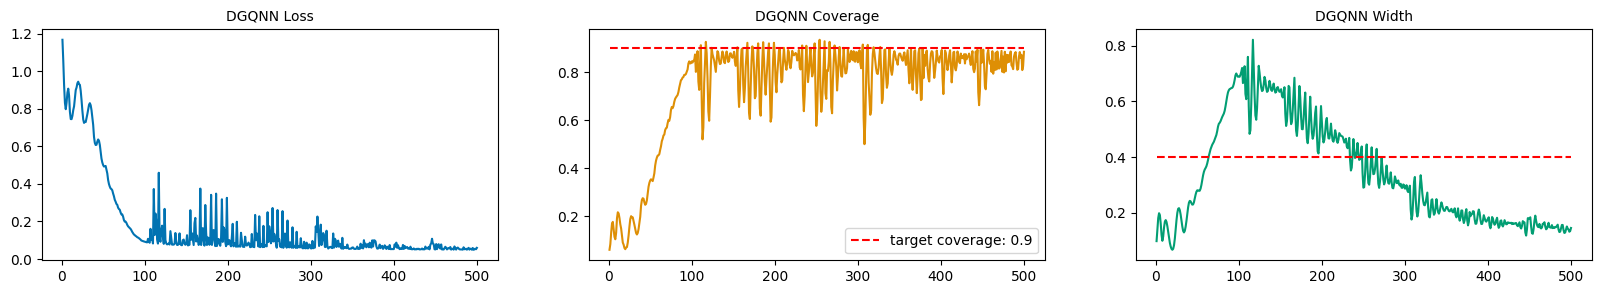

예측 관련 - Coverage Rate (CR) ⬆: 0.84, Mean Prediction Error (MPE) ⬇: 0.04
구간 관련 - Interval Width (IW) ⬇: 0.14, Sharpness ⬇: 0.02, Winkler Score (WS) ⬇: 0.14
종합 - MisCoverage Trade-off (MCT) ⬇: 0.01


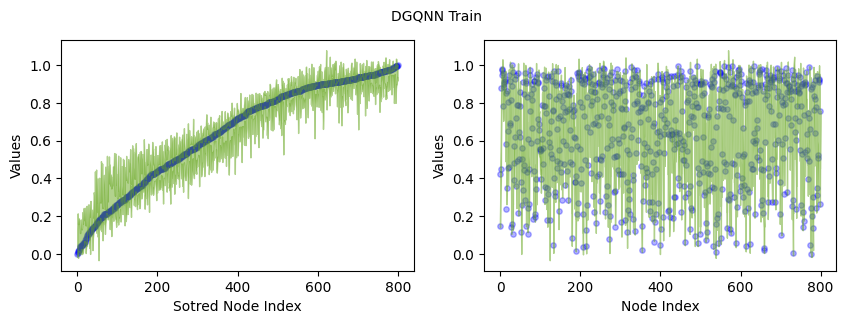

예측 관련 - Coverage Rate (CR) ⬆: 0.60, Mean Prediction Error (MPE) ⬇: 0.04
구간 관련 - Interval Width (IW) ⬇: 0.11, Sharpness ⬇: 0.02, Winkler Score (WS) ⬇: 0.12
종합 - MisCoverage Trade-off (MCT) ⬇: 0.03


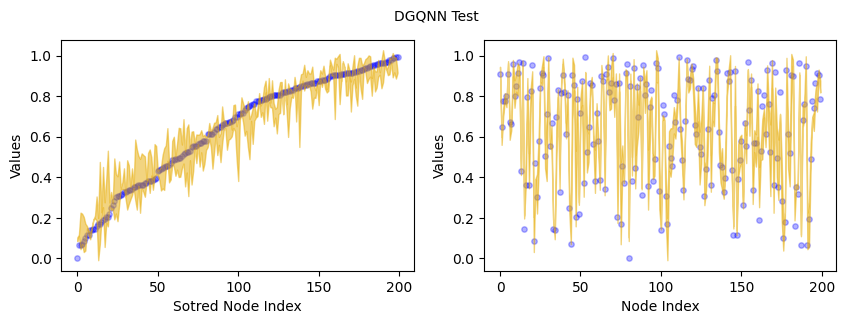

In [10]:
# DGQNN
in_dim = train_data.x.shape[1]
hidden_dim = 64
learning_rate = 1e-3
weight = 1e-3
num_epochs = 500
target=0.9
lr = 0.1
lw = 0.5

device = torch.device(f"cuda:0" if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)

model = GQNN_D(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
optimizer = optim.Adam([
    {'params': model.conv1.parameters(), 'lr': learning_rate},
    {'params': model.conv2.parameters(), 'lr': learning_rate},
    {'params': model.fc_pred.parameters(), 'lr': learning_rate},
    {'params': model.fc_tau.parameters(), 'lr': learning_rate * 0.1},  # tau에 작은 학습률
], weight_decay=weight)

criterion = IQRLoss(target_coverage=target, num_epochs=num_epochs, lambda_reg=lr, lambda_width=lw)

epochs = []
losses = []
coverages = []
widths = []
# for epoch in tqdm(range(num_epochs)):
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    preds_low, preds_upper, taus_low, taus_upper = model(train_data.x, train_data.edge_index)
    loss = criterion(preds_low, preds_upper, taus_low, taus_upper, train_data.y, epoch)
        
    loss.backward()
    optimizer.step()
    
    epochs.append(epoch+1)
    losses.append(loss.item())
    
    cvg, wdt = coverage_width(train_data.y, preds_low, preds_upper)
    coverages.append(cvg.item())
    widths.append(wdt.item())
    
    if epoch % (num_epochs // 50) == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.2f}, Coverage = {cvg.item():.2f}, Width = {wdt.item():.2f}")
        print('-' * 50)

# Loss 시각화
plt.figure(figsize=(20, 3))
plt.subplot(131)
plt.plot(epochs, losses, color=color[0])
plt.title('DGQNN Loss', size=10)

plt.subplot(132)
plt.plot(epochs, coverages, color=color[1])
plt.hlines(y=0.9, xmin=min(epochs), xmax=max(epochs), colors='red', linestyles='--', label='target coverage: 0.9')
plt.title('DGQNN Coverage', size=10)
plt.legend()

plt.subplot(133)
plt.plot(epochs, widths, color=color[2])
plt.hlines(y=0.4, xmin=min(epochs), xmax=max(epochs), colors='red', linestyles='--')
plt.title('DGQNN Width', size=10)
plt.show()     

model.eval()
test_data = test_data.to(device)

with torch.no_grad():
    preds_low, preds_upper, _, _ = model(train_data.x, train_data.edge_index)
    train_low_preds = preds_low.cpu().numpy()
    train_upper_preds = preds_upper.cpu().numpy()
    train_targets = train_data.y.cpu().numpy()
evaluate_model_performance(train_low_preds, train_upper_preds, train_targets, target=0.9)

pastel_colors = sns.color_palette('Dark2')
x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(train_data.x, train_data.y, train_low_preds, train_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('DGQNN Train', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[4], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), train_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), train_low_preds.squeeze(), train_upper_preds.squeeze(), color=pastel_colors[4], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

with torch.no_grad():
    preds_low, preds_upper, _, _ = model(test_data.x, test_data.edge_index)
    test_low_preds = preds_low.cpu().numpy()
    test_upper_preds = preds_upper.cpu().numpy()
    test_targets = test_data.y.cpu().numpy()
evaluate_model_performance(test_low_preds, test_upper_preds, test_targets, target=0.9)

x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(test_data.x, test_data.y, test_low_preds, test_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('DGQNN Test', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[5], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), test_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), test_low_preds.squeeze(), test_upper_preds.squeeze(), color=pastel_colors[5], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

In [5]:
def quantile_loss(y, y_hat, tau):
    diff = y - y_hat
    return torch.mean(torch.where(diff >= 0, tau * diff, (tau - 1) * diff))

def smoothed_quantile_loss(y, y_hat, tau, delta=0.1):
    diff = y - y_hat
    abs_diff = torch.abs(diff)
    loss = torch.where(abs_diff < delta, 0.5 * (diff / delta) ** 2, abs_diff - 0.5 * delta)
    return torch.mean(torch.where(diff >= 0, tau * loss, (1 - tau) * loss)) 

def quantile_loss_with_regularization(y, y_hat_low, y_hat_upper, tau_low, tau_upper, lambda_reg=0.1):
    qr_loss = quantile_loss(y, y_hat_low, tau_low) + quantile_loss(y, y_hat_upper, tau_upper)
    reg_loss = lambda_reg * torch.mean(y_hat_upper - y_hat_low)  # 구간 너비 패널티
    return qr_loss + reg_loss

def probabilistic_coverage_loss(y, y_low, y_upper, p):
    """
    확률 기반 Coverage Loss
    :param y: 실제 값 (torch.Tensor)
    :param y_low: 예측된 하한 값 (torch.Tensor)
    :param y_upper: 예측된 상한 값 (torch.Tensor)
    :param p: 목표 커버리지 확률 (float)
    :return: 확률 기반 Coverage Loss
    """
    inside = ((y_low <= y) & (y <= y_upper)).float()  # 구간 내 포함 여부 (0 또는 1)
    
    # Convert p to Tensor and ensure numerical stability
    epsilon = 1e-6
    p_tensor = torch.tensor(p, dtype=torch.float32)
    p_tensor = torch.clamp(p_tensor, epsilon, 1 - epsilon)
    
    # Compute the loss
    loss = -torch.mean(inside * torch.log(p_tensor) + (1 - inside) * torch.log(1 - p_tensor))
    return loss

def continuous_coverage_loss(y, y_low, y_upper):
    """
    연속적인 Coverage Loss
    :param y: 실제 값 (torch.Tensor)
    :param y_low: 예측된 하위 분위수 (torch.Tensor)
    :param y_upper: 예측된 상위 분위수 (torch.Tensor)
    :return: 연속적인 Coverage Loss
    """
    loss = torch.mean(torch.clamp(y_low - y, min=0) + torch.clamp(y - y_upper, min=0))
    return loss

def modified_coverage_loss(y, y_low, y_upper, p, lambda_width=0.1, epsilon=0.01):
    """
    수정된 Coverage Loss: 목표 커버리지에 도달하면 구간 확장을 억제
    :param y: 실제 값 (torch.Tensor)
    :param y_low: 예측된 하한 값 (torch.Tensor)
    :param y_upper: 예측된 상한 값 (torch.Tensor)
    :param p: 목표 커버리지 확률 (float)
    :param lambda_width: 구간 너비 패널티 강도 (float)
    :param epsilon: sigmoid 전환 부드러움 조절 (float)
    :return: 수정된 Coverage Loss
    """
    # 현재 커버리지 비율 계산
    inside = ((y_low <= y) & (y <= y_upper)).float()
    p_hat = torch.mean(inside)

    # 목표 커버리지와의 차이
    coverage_loss = (p - p_hat) ** 2

    # 구간 너비 패널티
    width_penalty = torch.mean(y_upper - y_low)

    # 가중치 계산 (sigmoid를 사용한 부드러운 전환)
    w = torch.sigmoid((p_hat - p) / epsilon)

    # 최종 손실: 커버리지 손실과 너비 패널티의 가중 합
    loss = (1 - w) * coverage_loss + w * lambda_width * width_penalty
    return loss


In [6]:
class GQNN_D(nn.Module):
    # tau와 preds 같이 출력
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc_tau = nn.Linear(hidden_dim, 1)
        self.fc_pred = nn.Linear(hidden_dim, 1)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        taus = torch.sigmoid(self.fc_tau(x))
        tau_low = 0.05 + 0.45 * taus
        tau_upper = 0.95 -0.45 * taus
        
        preds = self.fc_pred(x)
        scale = F.relu(torch.log1p(torch.abs(preds))) + 0.1
        scale = torch.clamp(scale, min=0.1, max=2.0)
        preds_low = preds - tau_low * scale
        preds_upper = preds + tau_upper * scale
        
        return preds_low, preds_upper, tau_low, tau_upper

class IQRLoss(nn.Module):
    def __init__(self, target_coverage=0.9, num_epochs=500, lambda_reg=0.1):
        super().__init__()
        self.alpha = target_coverage
        self.n = num_epochs
        self.lr = lambda_reg
        
    def forward(self, preds_low, preds_upper, tau_low, tau_upper, target, epoch):
        # Quantile Loss
        loss_low = quantile_loss(target, preds_low, tau_low)
        loss_upper = quantile_loss(target, preds_upper, tau_upper)
        qr_loss = 1.0 * loss_low + 1.5 * loss_upper
        # qr_loss = quantile_loss_with_regularization(target, preds_low, preds_upper, tau_low, tau_upper, lambda_reg=self.lr)
        
        # Coverage Loss
        coverage_loss = probabilistic_coverage_loss(target, preds_low, preds_upper, p=self.alpha)
        # coverage_loss = modified_coverage_loss(target, preds_low, preds_upper, p=self.alpha)
        
        # Width Loss
          
        loss = qr_loss + coverage_loss
        
        if epoch % (self.n // 50) == 0:
            print(f'QR Loss: {qr_loss.item():.2f}, Coverage Loss: {coverage_loss.item():.2f}')
        
        return loss

QR Loss: 0.68, Coverage Loss: 2.13
Epoch 0: Loss = 2.81, Coverage = 0.08, Width = 0.17
--------------------------------------------------
QR Loss: 0.32, Coverage Loss: 1.17
Epoch 10: Loss = 1.49, Coverage = 0.51, Width = 0.59
--------------------------------------------------
QR Loss: 0.23, Coverage Loss: 1.34
Epoch 20: Loss = 1.56, Coverage = 0.44, Width = 0.47
--------------------------------------------------
QR Loss: 0.20, Coverage Loss: 1.09
Epoch 30: Loss = 1.30, Coverage = 0.55, Width = 0.51
--------------------------------------------------
QR Loss: 0.20, Coverage Loss: 1.08
Epoch 40: Loss = 1.28, Coverage = 0.56, Width = 0.51
--------------------------------------------------
QR Loss: 0.19, Coverage Loss: 1.09
Epoch 50: Loss = 1.28, Coverage = 0.55, Width = 0.50
--------------------------------------------------
QR Loss: 0.18, Coverage Loss: 1.15
Epoch 60: Loss = 1.33, Coverage = 0.52, Width = 0.49
--------------------------------------------------
QR Loss: 0.17, Coverage Loss

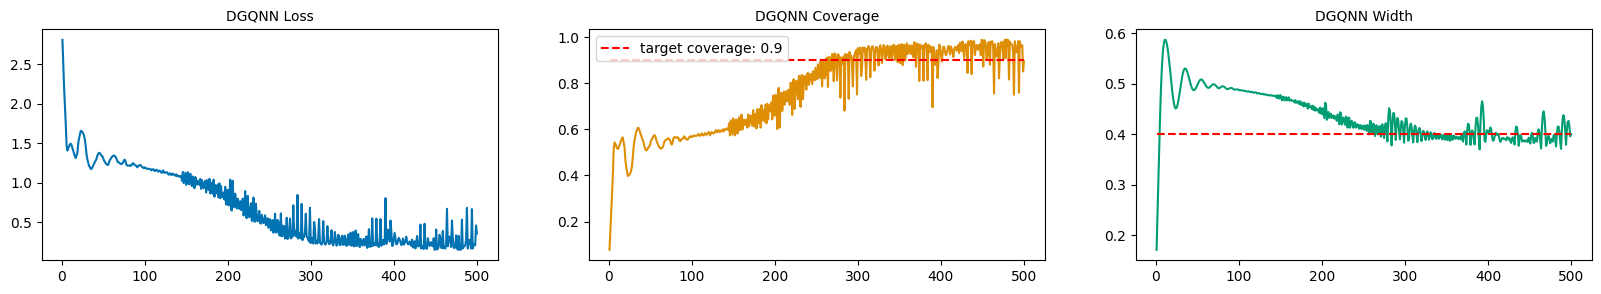

예측 관련 - Coverage Rate (CR) ⬆: 0.97, Mean Prediction Error (MPE) ⬇: 0.11
구간 관련 - Interval Width (IW) ⬇: 0.41, Sharpness ⬇: 0.18, Winkler Score (WS) ⬇: 0.41
종합 - MisCoverage Trade-off (MCT) ⬇: 0.03


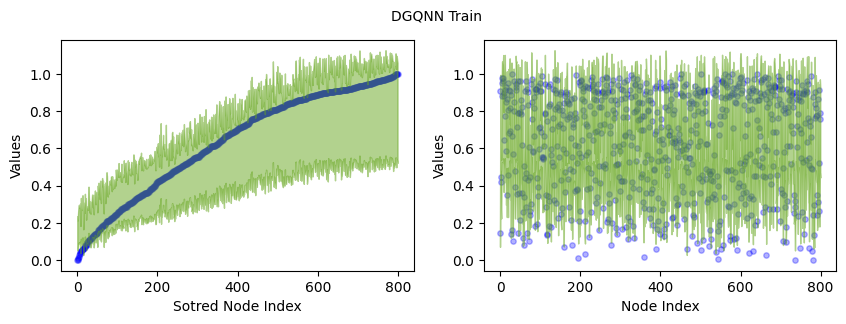

예측 관련 - Coverage Rate (CR) ⬆: 0.94, Mean Prediction Error (MPE) ⬇: 0.13
구간 관련 - Interval Width (IW) ⬇: 0.42, Sharpness ⬇: 0.19, Winkler Score (WS) ⬇: 0.42
종합 - MisCoverage Trade-off (MCT) ⬇: 0.01


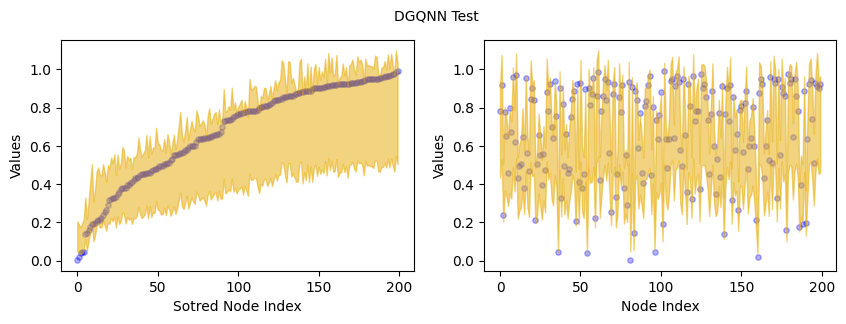

In [7]:
# DGQNN
in_dim = train_data.x.shape[1]
hidden_dim = 64
learning_rate = 1e-3
weight = 1e-3
num_epochs = 500
target=0.9
lr = 1

device = torch.device(f"cuda:0" if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)

model = GQNN_D(in_dim=in_dim, hidden_dim=hidden_dim).to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)
optimizer = optim.Adam([
    {'params': model.conv1.parameters(), 'lr': learning_rate},
    {'params': model.conv2.parameters(), 'lr': learning_rate},
    {'params': model.fc_pred.parameters(), 'lr': learning_rate},
    {'params': model.fc_tau.parameters(), 'lr': learning_rate * 0.1},  # tau에 작은 학습률
], weight_decay=weight)

criterion = IQRLoss(target_coverage=target, num_epochs=num_epochs, lambda_reg=lr)

epochs = []
losses = []
coverages = []
widths = []
# for epoch in tqdm(range(num_epochs)):
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    preds_low, preds_upper, taus_low, taus_upper = model(train_data.x, train_data.edge_index)
    loss = criterion(preds_low, preds_upper, taus_low, taus_upper, train_data.y, epoch)
        
    loss.backward()
    optimizer.step()
    
    epochs.append(epoch+1)
    losses.append(loss.item())
    
    cvg, wdt = coverage_width(train_data.y, preds_low, preds_upper)
    coverages.append(cvg.item())
    widths.append(wdt.item())
    
    if epoch % (num_epochs // 50) == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.2f}, Coverage = {cvg.item():.2f}, Width = {wdt.item():.2f}")
        print('-' * 50)

# Loss 시각화
plt.figure(figsize=(20, 3))
plt.subplot(131)
plt.plot(epochs, losses, color=color[0])
plt.title('DGQNN Loss', size=10)

plt.subplot(132)
plt.plot(epochs, coverages, color=color[1])
plt.hlines(y=0.9, xmin=min(epochs), xmax=max(epochs), colors='red', linestyles='--', label='target coverage: 0.9')
plt.title('DGQNN Coverage', size=10)
plt.legend()

plt.subplot(133)
plt.plot(epochs, widths, color=color[2])
plt.hlines(y=0.4, xmin=min(epochs), xmax=max(epochs), colors='red', linestyles='--')
plt.title('DGQNN Width', size=10)
plt.show()     

model.eval()
test_data = test_data.to(device)

with torch.no_grad():
    preds_low, preds_upper, _, _ = model(train_data.x, train_data.edge_index)
    train_low_preds = preds_low.cpu().numpy()
    train_upper_preds = preds_upper.cpu().numpy()
    train_targets = train_data.y.cpu().numpy()
evaluate_model_performance(train_low_preds, train_upper_preds, train_targets, target=0.9)

pastel_colors = sns.color_palette('Dark2')
x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(train_data.x, train_data.y, train_low_preds, train_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('DGQNN Train', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[4], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), train_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), train_low_preds.squeeze(), train_upper_preds.squeeze(), color=pastel_colors[4], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

with torch.no_grad():
    preds_low, preds_upper, _, _ = model(test_data.x, test_data.edge_index)
    test_low_preds = preds_low.cpu().numpy()
    test_upper_preds = preds_upper.cpu().numpy()
    test_targets = test_data.y.cpu().numpy()
evaluate_model_performance(test_low_preds, test_upper_preds, test_targets, target=0.9)

x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(test_data.x, test_data.y, test_low_preds, test_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('DGQNN Test', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[5], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), test_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), test_low_preds.squeeze(), test_upper_preds.squeeze(), color=pastel_colors[5], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

In [31]:
class GQNN_D2(nn.Module):
    def __init__(self, in_dim, hidden_dim, target_coverage=0.9, num_epochs=500, lambda_reg=0.1):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc_tau = nn.Linear(hidden_dim, 1)
        self.fc_pred = nn.Linear(hidden_dim, 1)
        self.fc_scale = nn.Linear(hidden_dim, 1)  # scale을 위한 추가 레이어
        self.tau_range = nn.Parameter(torch.tensor(0.4)) # 학습 가능한 tau_range
        
        self.alpha = target_coverage
        self.num_epochs = num_epochs
        self.lr = lambda_reg
        
        nn.init.xavier_uniform_(self.fc_tau.weight)
        nn.init.xavier_uniform_(self.fc_pred.weight)
        nn.init.xavier_uniform_(self.fc_scale.weight)
    
    def quantile_loss(self, target, preds, tau):
        diff = target - preds
        return torch.mean(torch.where(diff >= 0, tau * diff, (tau - 1) * diff))
    
    def coverage_loss(self, target, preds_low, preds_upper):
        inside = ((preds_low <= target) & (target <= preds_upper)).float()
        p_hat = torch.mean(inside)
        coverage_loss = (self.alpha - p_hat) ** 2
        width_penalty = torch.mean(preds_upper - preds_low)
        w = torch.sigmoid((p_hat - self.alpha) / 0.01)
        lambda_reg = self.lr * (1 + epoch / self.num_epochs)
        coverage_weight = 2.0 if p_hat < self.alpha else 1.0
        return (1 - w) * coverage_loss * coverage_weight + w * lambda_reg * width_penalty 
        # return coverage_loss * coverage_weight

    def probabilistic_coverage_loss(self, target, preds_low, preds_upper, p):
        inside = ((preds_low <= target) & (target <= preds_upper)).float()  # 구간 내 포함 여부 (0 또는 1)
        
        # Convert p to Tensor and ensure numerical stability
        epsilon = 1e-6
        p_tensor = torch.tensor(p, dtype=torch.float32)
        p_tensor = torch.clamp(p_tensor, epsilon, 1 - epsilon)
        
        # Compute the loss
        loss = -torch.mean(inside * torch.log(p_tensor) + (1 - inside) * torch.log(1 - p_tensor))
        return loss
 
    def forward(self, x, edge_index, target, epoch):
        # GNN 레이어
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        # 단일 tau 출력
        tau = torch.sigmoid(self.fc_tau(x))  
        progress = min(epoch / self.num_epochs, 1.0)
        tau_center = 0.5
        tau_range = torch.clamp(self.tau_range, 0.0, 0.4) * progress
        
        tau_low = tau_center - tau_range * tau
        tau_upper = tau_center + tau_range * (1 - tau)
        tau_low = torch.clamp(tau_low, 0.1, 0.49)
        tau_upper = torch.clamp(tau_upper, 0.51, 0.9)
        
        preds = self.fc_pred(x)
        scale = F.relu(self.fc_scale(x)) + 0.5
        scale = torch.clamp(scale, min=0.5, max=2.0)
        preds_low = preds - tau_low * scale
        preds_upper = preds + tau_upper * scale
        
        loss_low = self.quantile_loss(target, preds_low, tau_low)
        loss_upper = self.quantile_loss(target, preds_upper, tau_upper)
        qr_loss = 1.5 * loss_low + 1.0 * loss_upper
        
        coverage_loss = self.coverage_loss(target, preds_low, preds_upper)
        coverage_loss = self.probabilistic_coverage_loss(target, preds_low, preds_upper, p=self.alpha)
        total_loss = qr_loss + coverage_loss
        
        if epoch % (self.num_epochs // 50) == 0:
            print(f"Epoch {epoch}: QR Loss = {qr_loss.item():.2f}, Coverage Loss = {coverage_loss.item():.2f}")
        
        return preds_low, preds_upper, tau_low, tau_upper, total_loss

Epoch 0: QR Loss = 0.91, Coverage Loss = 1.75
Epoch 0: Loss = 2.66, Coverage = 0.25, Width = 0.80
--------------------------------------------------
Epoch 10: QR Loss = 0.45, Coverage Loss = 1.21
Epoch 10: Loss = 1.66, Coverage = 0.50, Width = 0.50
--------------------------------------------------
Epoch 20: QR Loss = 0.41, Coverage Loss = 1.23
Epoch 20: Loss = 1.64, Coverage = 0.49, Width = 0.50
--------------------------------------------------
Epoch 30: QR Loss = 0.39, Coverage Loss = 1.06
Epoch 30: Loss = 1.45, Coverage = 0.56, Width = 0.50
--------------------------------------------------
Epoch 40: QR Loss = 0.37, Coverage Loss = 1.10
Epoch 40: Loss = 1.47, Coverage = 0.55, Width = 0.50
--------------------------------------------------
Epoch 50: QR Loss = 0.36, Coverage Loss = 1.00
Epoch 50: Loss = 1.37, Coverage = 0.59, Width = 0.50
--------------------------------------------------
Epoch 60: QR Loss = 0.35, Coverage Loss = 0.99
Epoch 60: Loss = 1.35, Coverage = 0.60, Width = 0

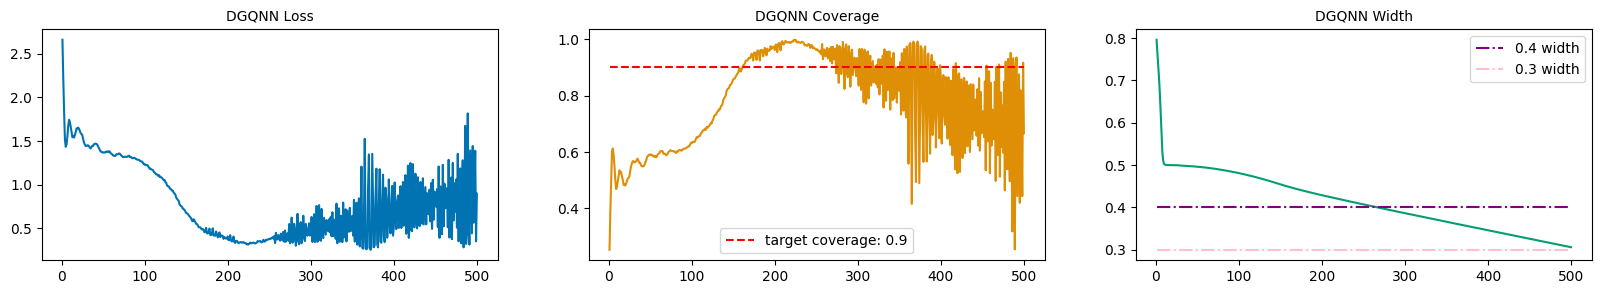

In [32]:
# DGQNN_2
in_dim = train_data.x.shape[1]
hidden_dim = 64
learning_rate = 1e-3
weight = 1e-3
num_epochs = 500
target_coverage = 0.9
lambda_reg = 0.01

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_data = train_data.to(device)

model = GQNN_D2(
    in_dim=in_dim,
    hidden_dim=hidden_dim,
    target_coverage=target_coverage,
    num_epochs=num_epochs,
    lambda_reg=lambda_reg
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight)

epochs = []
losses = []
coverages = []
widths = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    preds_low, preds_upper, tau_low, tau_upper, loss = model(
        train_data.x, train_data.edge_index, train_data.y, epoch
    )
    
    loss.backward()
    optimizer.step()
    
    epochs.append(epoch + 1)
    losses.append(loss.item())
    
    cvg, wdt = coverage_width(train_data.y, preds_low, preds_upper)
    coverages.append(cvg.item())
    widths.append(wdt.item())
    
    if epoch % (num_epochs // 50) == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.2f}, Coverage = {cvg.item():.2f}, Width = {wdt.item():.2f}")
        print('-' * 50)
        
# 시각화
plt.figure(figsize=(20, 3))
plt.subplot(131)
plt.plot(epochs, losses, color=color[0])
plt.title('DGQNN Loss', size=10)

plt.subplot(132)
plt.plot(epochs, coverages, color=color[1])
plt.hlines(y=0.9, xmin=min(epochs), xmax=max(epochs), colors='red', linestyles='--', label='target coverage: 0.9')
plt.title('DGQNN Coverage', size=10)
plt.legend()

plt.subplot(133)
plt.plot(epochs, widths, color=color[2])
plt.hlines(y=0.4, xmin=min(epochs), xmax=max(epochs), colors='purple', linestyles='-.', label='0.4 width')
plt.hlines(y=0.3, xmin=min(epochs), xmax=max(epochs), colors='pink', linestyles='-.', label='0.3 width')
plt.title('DGQNN Width', size=10)
plt.legend()
plt.show()     

예측 관련 - Coverage Rate (CR) ⬆: 0.36, Mean Prediction Error (MPE) ⬇: 0.16
구간 관련 - Interval Width (IW) ⬇: 0.31, Sharpness ⬇: 0.09, Winkler Score (WS) ⬇: 0.32
종합 - MisCoverage Trade-off (MCT) ⬇: 0.16


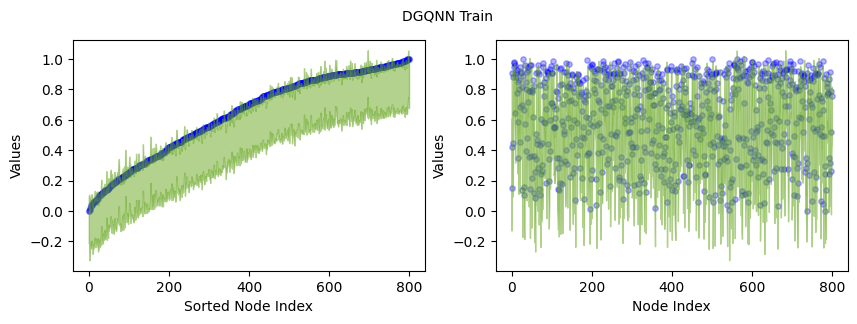

예측 관련 - Coverage Rate (CR) ⬆: 0.46, Mean Prediction Error (MPE) ⬇: 0.16
구간 관련 - Interval Width (IW) ⬇: 0.31, Sharpness ⬇: 0.09, Winkler Score (WS) ⬇: 0.33
종합 - MisCoverage Trade-off (MCT) ⬇: 0.14


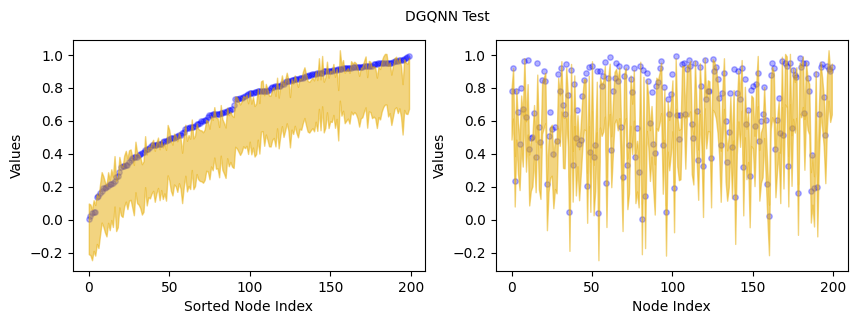

In [33]:
# 모델 평가
model.eval()
test_data = test_data.to(device)

# 학습 데이터 평가
with torch.no_grad():
    # num_epochs - 1을 epoch로 사용 (학습 완료 상태 가정)
    preds_low, preds_upper, _, _, _ = model(train_data.x, train_data.edge_index, train_data.y, num_epochs - 1)
    train_low_preds = preds_low.cpu().numpy()
    train_upper_preds = preds_upper.cpu().numpy()
    train_targets = train_data.y.cpu().numpy()
    evaluate_model_performance(train_low_preds, train_upper_preds, train_targets, target=0.9)

# 시각화
pastel_colors = sns.color_palette('Dark2')
x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(train_data.x.cpu().numpy(), train_data.y.cpu().numpy(), train_low_preds, train_upper_preds)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('DGQNN Train', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[4], alpha=0.5)
axes[0].set_xlabel("Sorted Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), train_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), train_low_preds.squeeze(), train_upper_preds.squeeze(), color=pastel_colors[4], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

# 테스트 데이터 평가
with torch.no_grad():
    preds_low, preds_upper, _, _, _ = model(test_data.x, test_data.edge_index, test_data.y, num_epochs - 1)
    test_low_preds = preds_low.cpu().numpy()
    test_upper_preds = preds_upper.cpu().numpy()
    test_targets = test_data.y.cpu().numpy()
    evaluate_model_performance(test_low_preds, test_upper_preds, test_targets, target=0.9)

# 시각화
x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(test_data.x.cpu().numpy(), test_data.y.cpu().numpy(), test_low_preds, test_upper_preds)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('DGQNN Test', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[5], alpha=0.5)
axes[0].set_xlabel("Sorted Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), test_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), test_low_preds.squeeze(), test_upper_preds.squeeze(), color=pastel_colors[5], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

In [ ]:

model.eval()
test_data = test_data.to(device)

with torch.no_grad():
    preds_low, preds_upper, _, _ = model(train_data.x, train_data.edge_index)
    train_low_preds = preds_low.cpu().numpy()
    train_upper_preds = preds_upper.cpu().numpy()
    train_targets = train_data.y.cpu().numpy()
evaluate_model_performance(train_low_preds, train_upper_preds, train_targets, target=0.9)

pastel_colors = sns.color_palette('Dark2')
x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(train_data.x, train_data.y, train_low_preds, train_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('DGQNN Train', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[4], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), train_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), train_low_preds.squeeze(), train_upper_preds.squeeze(), color=pastel_colors[4], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

with torch.no_grad():
    preds_low, preds_upper, _, _ = model(test_data.x, test_data.edge_index)
    test_low_preds = preds_low.cpu().numpy()
    test_upper_preds = preds_upper.cpu().numpy()
    test_targets = test_data.y.cpu().numpy()
evaluate_model_performance(test_low_preds, test_upper_preds, test_targets, target=0.9)

x_st, y_st, (low_r_st, upper_r_st) = sort_by_y(test_data.x, test_data.y, test_low_preds, test_upper_preds)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
fig.suptitle('DGQNN Test', size=10)

axes[0].scatter(range(len(x_st)), y_st, alpha=0.3, color='blue', label="True Values", s=15)
axes[0].fill_between(range(len(x_st)), low_r_st, upper_r_st, color=pastel_colors[5], alpha=0.5)
axes[0].set_xlabel("Sotred Node Index") 
axes[0].set_ylabel("Values")

axes[1].scatter(range(len(x_st)), test_targets, alpha=0.3, color='blue', label="True Values", s=15)
axes[1].fill_between(range(len(x_st)), test_low_preds.squeeze(), test_upper_preds.squeeze(), color=pastel_colors[5], alpha=0.5)
axes[1].set_xlabel("Node Index")  
axes[1].set_ylabel("Values") 
plt.show()

### 추가 데이터셋

In [ ]:
import torch
from torch_geometric.utils import erdos_renyi_graph
from torch_geometric.data import Data

# ER 그래프 생성
num_nodes = 100
edge_prob = 0.2
edge_index = erdos_renyi_graph(num_nodes, edge_prob)

# 노드 피처와 타겟 추가
x = torch.randn(num_nodes, 16)  # 노드 피처 (16차원)
y = x.sum(dim=1).unsqueeze(1) + torch.randn(num_nodes, 1) * 0.1  # 노드별 타겟 (회귀용)

# Data 객체 생성
data = Data(x=x, edge_index=edge_index, y=y)
print(f"노드 수: {data.num_nodes}, 엣지 수: {data.num_edges}")

In [ ]:
import torch
from torch_geometric.utils import barabasi_albert_graph
from torch_geometric.data import Data

# BA 그래프 생성
num_nodes = 100
m = 2  # 새 노드가 연결할 기존 노드 수
edge_index = barabasi_albert_graph(num_nodes, m)

# 노드 피처와 타겟 추가
x = torch.randn(num_nodes, 16)
y = torch.log1p(torch.arange(num_nodes, dtype=torch.float)).unsqueeze(1)  # 예: 노드 순서 기반 타겟

# Data 객체 생성
data = Data(x=x, edge_index=edge_index, y=y)
print(f"노드 수: {data.num_nodes}, 엣지 수: {data.num_edges}")

In [ ]:
import torch
import networkx as nx
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data

# WS 그래프 생성 (networkx 사용)
G = nx.watts_strogatz_graph(n=100, k=4, p=0.1)
data = from_networkx(G)

# 노드 피처와 타겟 추가
data.x = torch.randn(data.num_nodes, 16)
data.y = torch.randn(data.num_nodes, 1)  # 랜덤 타겟

print(f"노드 수: {data.num_nodes}, 엣지 수: {data.num_edges}")

### 실험 종합 성능

In [3]:
SQR_CR_tr = [0.77,0.77,0.87,0.84,0.88,0.92,0.88,0.89,0.93,0.93,0.85,0.76,0.95,0.84,0.89]
RQR_CR_tr = [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.96,0.90,0.00,0.90]
CP_CR_tr = [0.97,0.93,0.94,0.91,0.93,0.91,0.92,0.92,0.89,0.98,0.98,0.97,0.98,0.94,0.88]
BNN_CR_tr = [1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00]
MCDropout_CR_tr = [0.39,0.51,0.40,0.64,0.40,0.28,0.43,0.31,0.39,0.37,0.38,0.45,0.10,0.29,0.19]
Our_CR_tr = [1.00,0.98,0.98,0.95,1.00,0.94,0.94,0.95,0.87,1.00,1.00,1.00,1.00,0.85,0.86] 

SQR_IW_tr = [0.73,0.33,0.62,0.11,0.26,0.29,0.45,0.22,0.36,0.03,0.01,0.00,0.01,0.32,0.21]
RQR_IW_tr = [-0.82,-0.54,-0.68,-0.39,-0.83,-0.38,-0.54,-0.36,-0.38,-0.43,-0.16,0.08,0.15,-0.57,0.33]
CP_IW_tr = [0.16,0.43,0.34,0.16,0.13,0.26,0.50,0.26,0.29,0.17,0.12,0.07,0.13,0.40,0.22]
BNN_IW_tr = [3.61,3.51,3.68,3.66,3.79,3.41,3.64,3.73,3.71,3.56,3.48,3.72,3.55,4.00,3.29]
MCDropout_IW_tr = [0.35,0.26,0.29,0.12,0.37,0.10,0.21,0.10,0.11,0.16,0.02,0.01,0.02,0.11,0.07]
Our_IW_tr = [0.70,0.61,0.67,0.23,0.70,0.32,0.67,0.30,0.33,0.60,0.13,0.12,0.13,0.24,0.20] 

In [4]:
SQR_CR_ts = [0.91,0.80,0.92,0.90,0.92,0.94,0.90,0.90,0.91,0.31,0.28,0.42,0.30,0.82,0.84]
RQR_CR_ts = [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.95,0.87,0.00,0.87]
CP_CR_ts = [0.95,0.91,0.91,0.91,0.90,0.91,0.93,0.93,0.87,0.94,0.91,0.91,0.89,0.90,0.85]
BNN_CR_ts = [1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00]
MCDropout_CR_ts = [0.70,0.78,0.74,0.73,0.73,0.62,0.74,0.66,0.69,0.73,0.67,0.71,0.43,0.67,0.53]
Our_CR_ts = [0.98,0.94,0.96,0.79,0.99,0.97,0.94,0.94,0.86,1.00,0.94,0.97,0.92,0.79,0.86] 

SQR_IW_ts = [0.78,0.34,0.67,0.12,0.28,0.28,0.46,0.22,0.36,0.03,0.01,0.00,0.02,0.32,0.20]
RQR_IW_ts = [-0.82,-0.54,-0.68,-0.37,-0.83,-0.38,-0.54,-0.36,-0.38,-0.42,-0.16,0.08,0.15,-0.56,0.31]
CP_IW_ts = [0.16,0.43,0.34,0.16,0.13,0.26,0.50,0.26,0.29,0.17,0.12,0.07,0.13,0.40,0.22]
BNN_IW_ts = [3.46,3.17,3.33,3.48,3.39,3.01,3.40,3.54,3.66,3.58,3.51,3.49,3.18,3.06,3.54]
MCDropout_IW_ts = [1.60,1.18,1.31,1.86,1.37,1.21,1.35,1.84,1.66,1.78,1.97,1.78,1.41,1.98,1.70]
Our_IW_ts = [0.69,0.62,0.68,0.24,0.72,0.32,0.67,0.30,0.33,0.60,0.13,0.12,0.13,0.25,0.20] 

In [11]:
ROR_IW_tr_abs = np.abs(RQR_IW_tr)
ROR_IW_ts_abs = np.abs(RQR_IW_ts)

In [12]:
print(round(np.mean(SQR_CR_tr), 2))
print(round(np.mean(RQR_CR_tr), 2))
print(round(np.mean(CP_CR_tr), 2))
print(round(np.mean(BNN_CR_tr), 2))
print(round(np.mean(MCDropout_CR_tr), 2))
print(round(np.mean(Our_CR_tr), 2))

print('-'* 50)

print(round(np.mean(SQR_CR_ts), 2))
print(round(np.mean(RQR_CR_ts), 2))
print(round(np.mean(CP_CR_ts), 2))
print(round(np.mean(BNN_CR_ts), 2))
print(round(np.mean(MCDropout_CR_ts), 2))
print(round(np.mean(Our_CR_ts), 2))

0.86
0.18
0.94
1.0
0.37
0.95
--------------------------------------------------
0.74
0.18
0.91
1.0
0.68
0.92


In [13]:
print(round(np.mean(SQR_IW_tr), 2))
print(round(np.mean(ROR_IW_tr_abs), 2))
print(round(np.mean(CP_IW_tr), 2))
print(round(np.mean(BNN_IW_tr), 2))
print(round(np.mean(MCDropout_IW_tr), 2))
print(round(np.mean(Our_IW_tr), 2))

print('-'* 50)

print(round(np.mean(SQR_IW_ts), 2))
print(round(np.mean(ROR_IW_ts_abs), 2))
print(round(np.mean(CP_IW_ts), 2))
print(round(np.mean(BNN_IW_ts), 2))
print(round(np.mean(MCDropout_IW_ts), 2))
print(round(np.mean(Our_IW_ts), 2))

0.26
0.44
0.24
3.62
0.15
0.4
--------------------------------------------------
0.27
0.44
0.24
3.39
1.6
0.4


In [35]:
# 데이터 정리
methods = ["SQR", "RQR", "CP", "BNN", "MCDropout", "Our"]
CR_tr_values = [SQR_CR_tr, RQR_CR_tr, CP_CR_tr, BNN_CR_tr, MCDropout_CR_tr, Our_CR_tr]
IW_tr_values = [SQR_IW_tr, ROR_IW_tr_abs, CP_IW_tr, BNN_IW_tr, MCDropout_IW_tr, Our_IW_tr]
CR_ts_values = [SQR_CR_ts, RQR_CR_ts, CP_CR_ts, BNN_CR_ts, MCDropout_CR_ts, Our_CR_ts]
IW_ts_values = [SQR_IW_ts, ROR_IW_ts_abs, CP_IW_ts, BNN_IW_ts, MCDropout_IW_ts, Our_IW_ts]

# 데이터프레임 생성
df_tr_list = []
for method, cr_list, iw_list in zip(methods, CR_tr_values, IW_tr_values):
    temp_df = pd.DataFrame({"Method": [method] * len(cr_list), "CR": cr_list, "IW": iw_list})
    df_tr_list.append(temp_df)

df_ts_list = []
for method, cr_list, iw_list in zip(methods, CR_ts_values, IW_ts_values):
    temp_df = pd.DataFrame({"Method": [method] * len(cr_list), "CR": cr_list, "IW": iw_list})
    df_ts_list.append(temp_df)

df_tr = pd.concat(df_tr_list, ignore_index=True)
df_ts = pd.concat(df_ts_list, ignore_index=True)

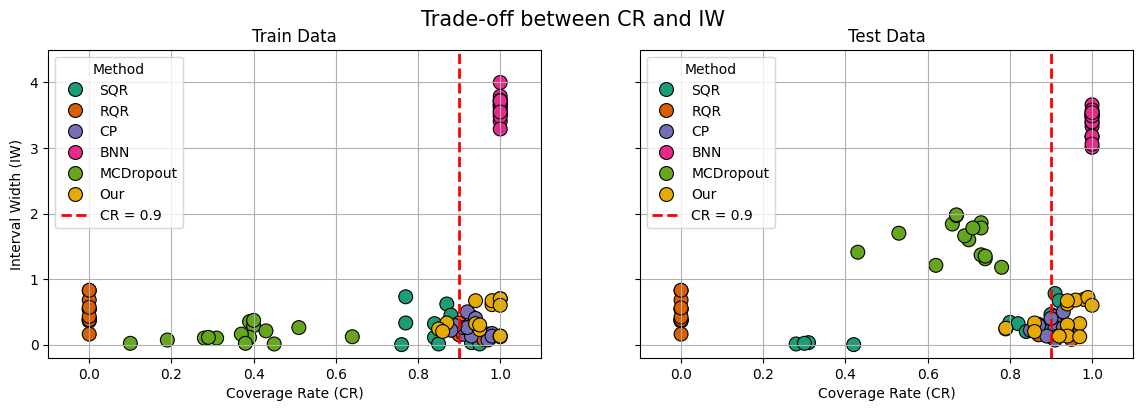

In [49]:
palette = sns.color_palette("Dark2", n_colors=len(df_tr["Method"].unique()))

fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=True)
fig.suptitle("Trade-off between CR and IW", fontsize=15)  # 전체 제목 추가

sns.scatterplot(data=df_tr, x="CR", y="IW", hue="Method", palette=palette, s=100, edgecolor="black", ax=ax[0])
ax[0].axvline(x=0.9, color='red', linestyle='--', linewidth=2, label="CR = 0.9")
ax[0].set_xlabel("Coverage Rate (CR)", fontsize=10)
ax[0].set_ylabel("Interval Width (IW)", fontsize=10)
ax[0].set_title("Train Data", fontsize=12)
ax[0].set_xlim(-0.1, 1.1)
ax[0].set_ylim(-0.2, 4.5)
ax[0].grid(True)
ax[0].legend(title="Method", fontsize=10)

sns.scatterplot(data=df_ts, x="CR", y="IW", hue="Method", palette=palette, s=100, edgecolor="black", ax=ax[1])
ax[1].axvline(x=0.9, color='red', linestyle='--', linewidth=2, label="CR = 0.9")
ax[1].set_xlabel("Coverage Rate (CR)", fontsize=10)
ax[1].set_title("Test Data", fontsize=12)
ax[1].set_xlim(-0.1, 1.1)
ax[1].set_ylim(-0.2, 4.5)
ax[1].grid(True)
ax[1].legend(title="Method", fontsize=10)

# plt.tight_layout(rect=[0, 0, 1, 0.95])  # 제목과 겹치지 않도록 조정

# 그래프 출력
plt.show()